# 기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 생성하기


# 기초부터 시작하는 NLP:  문자-단위 RNN으로 이름 생성하기

**Author**: [Sean Robertson](https://github.com/spro/practical-pytorch)
  **번역**: [황성수](https://github.com/adonisues)

이 튜토리얼은 3개로 이뤄진 "기초부터 시작하는 NLP"의 2번째 튜토리얼입니다.
`첫번째 튜토리얼 </intermediate/char_rnn_classification_tutorial>`
에서는 이름의 언어를 분류하기 위해 RNN을 사용했습니다.
이번에는 반대로 언어로 이름을 생성할 예정입니다.

::

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

우리는 몇 개의 선형 계층으로 작은 RNN을 직접 만들고 있습니다.
이전 튜토리얼인 이름을 읽은 후 그 언어를 예측하는 것과의 큰 차이점은
언어를 입력하고 한 번에 한 글자를 생성하여 출력하는 것입니다.
언어 형성(단어 또는 다른 고차원 구조로도 수행될 수 있음)을 위해
문자를 반복적으로 예측하는 것을 "언어 모델" 이라고 합니다.

**추천 자료:**

Pytorch를 설치했고, Python을 알고, Tensor를 이해한다고 가정합니다:

-  https://pytorch.org/ 설치 안내
-  :doc:`/beginner/deep_learning_60min_blitz` PyTorch 시작하기
-  :doc:`/beginner/pytorch_with_examples` 넓고 깊은 통찰을 위한 자료
-  :doc:`/beginner/former_torchies_tutorial` 이전 Lua Torch 사용자를 위한 자료

RNN과 작동 방식을 아는 것 또한 유용합니다:

-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)_
   실생활 예제를 보여 줍니다.
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)_
   LSTM에 관한 것이지만 RNN에 관해서도 유익합니다.

이전 튜토리얼도 추천합니다. :doc:`/intermediate/char_rnn_classification_tutorial`


## 데이터 준비

.. Note::
   [여기](https://download.pytorch.org/tutorial/data.zip)
   에서 데이터를 다운 받고, 현재 디렉토리에 압축을 푸십시오.

이 과정의 더 자세한 사항은 지난 튜토리얼을 보십시오.
요약하면, 줄마다 이름이 적힌 텍스트 파일 ``data/names/[Language].txt`` 있습니다.
이것을 array로 분리하고, Unicode를 ASCII로 변경하고,
사전 ``{language: [names ...]}`` 을 만들어서 마무리합니다.


In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # EOS(end of sentence) 기호 추가

def findFiles(path): return glob.glob(path)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []
for filename in findFiles('/content/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 19 ['Greek', 'Korean', 'Dutch', 'Czech', 'French', 'Spanish', 'Portuguese', 'Irish', 'Polish', 'Japanese', 'German', 'Scottish', 'eng-fra', 'Russian', 'Vietnamese', 'Chinese', 'Arabic', 'English', 'Italian']
O'Neal


## 네트워크 생성

이 네트워크는 [지난 튜토리얼의 RNN](#Creating-the-Network)_ 이
다른 입력들과 연결되는 category tensor를 추가 인자로 가지게 확장합니다.
category tensor는 문자 입력과 마찬가지로 one-hot 벡터입니다.

역자주: 기존 입력과 category tensor를 결합하여 입력으로 사용하기 때문에
입력의 사이즈가 n_categories 만큼 커집니다.

우리는 출력을 다음 문자의 확률로 해석합니다. 샘플링 할 때,
가장 확률이 높은 문자가 다음 입력 문자로 사용됩니다.

더 나은 동작을 위해 두 번째 선형 레이어
``o2o`` (은닉과 출력을 결합한 후) 를 추가했습니다 .
또한 Drop-out 계층이 있습니다. 이 계층은 주어진 확률(여기서는 0.1)로
[무작위로 입력을 0 #](https://arxiv.org/abs/1207.0580)_ 으로 만듭니다.
일반적으로 입력을 흐리게 해서 과적합을 막는 데 사용됩니다.
여기서 우리는 고의로 일부 혼돈을 추가하고 샘플링 다양성을 높이기
위해 네트워크의 마지막에 이것을 사용합니다.

.. figure:: https://i.imgur.com/jzVrf7f.png
   :alt:





In [5]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## 학습
학습 준비
----------------------

제일 먼저 (category, line)의 무작위 쌍을 얻는 함수:


In [6]:
import random

# 목록에서 무작위 아이템 반환
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# 임의의 category 및 그 category에서 무작위 줄(이름) 얻기
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

각 시간 단계 마다 (즉, 학습 단어의 각 문자 마다) 네트워크의 입력은
``(언어, 현재 문자, 은닉 상태)`` 가 되고, 출력은
``(다음 문자, 다음 은닉 상태)`` 가 된다. 따라서 각 학습 세트 마다
언어, 입력 문자의 세트, 출력/목표 문자의 세트가 필요하다.

각 시간 단계마다 현재 문자에서 다음 문자를 예측하기 때문에,
문자 쌍은 한 줄(하나의 이름)에서 연속된 문자 그룹입니다. - 예를 들어 ``"ABCD<EOS>"`` 는
("A", "B"), ("B", "C"), ("C", "D"), ("D", "EOS") 로 생성합니다.

.. figure:: https://i.imgur.com/JH58tXY.png
   :alt:

Category(언어) Tensor는 ``<1 x n_categories>`` 크기의 [One-hot
Tensor](https://en.wikipedia.org/wiki/One-hot)_ 입니다.
학습시에 모든 시간 단계에서 네트워크에 이것을 전달합니다.
- 이것은 설계 선택사항으로, 초기 은닉 상태 또는
또 다른 전략의 부분으로 포함될 수 있습니다.




In [7]:
# Category를 위한 One-hot 벡터
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# 입력을 위한 처음부터 마지막 문자(EOS 제외)까지의  One-hot 행렬
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# 목표를 위한 두번째 문자 부터 마지막(EOS)까지의 ``LongTensor``
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

학습 동안 편의를 위해 무작위로 (category[언어], line[이름])을 가져오고
그것을 필요한 형태 (category[언어], input[현재 문자], target[다음 문자]) Tensor로 바꾸는
``randomTrainingExample`` 함수를 만들 예정입니다.




In [8]:
# 임의의 Category에서 Category, Input, Target Tensor를 만듭니다.
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

### 네트워크 학습

마지막 출력만 사용하는 분류와 달리, 모든 단계에서 예측을 수행하므로
모든 단계에서 손실을 계산합니다.

Autograd의 마법이 각 단계의 손실들을 간단하게 합하고 마지막에
역전파를 호출하게 해줍니다.




In [9]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

학습에 걸리는 시간을 추적하기 위해 사람이 읽을 수 있는 문자열을
반환하는``timeSince (timestamp)`` 함수를 추가합니다:




In [10]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

학습은 일상적인 일입니다. - 몇 번 train() 을 호출하고, 몇 분 정도
기다렸다가 ``print_every`` 마다 현재 시간과 손실을 출력하고,
나중에 도식화를 위해  ``plot_every`` 마다 ``all_losses`` 에
평균 손실을 저장합니다.




In [11]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # ``plot_every`` 마다 초기화

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 22s (5000 5%) 2.6110
0m 43s (10000 10%) 3.2532
1m 5s (15000 15%) 3.2984
1m 27s (20000 20%) 3.3878
1m 50s (25000 25%) 2.7061
2m 13s (30000 30%) 2.5531
2m 34s (35000 35%) 1.4603
2m 57s (40000 40%) 2.5271
3m 18s (45000 45%) 2.8906
3m 40s (50000 50%) 3.4909
4m 2s (55000 55%) 1.9042
4m 23s (60000 60%) 2.8996
4m 46s (65000 65%) 2.3512
5m 8s (70000 70%) 2.8111
5m 30s (75000 75%) 1.5869
5m 51s (80000 80%) 2.6390
6m 15s (85000 85%) 2.0237
6m 37s (90000 90%) 2.5581
6m 58s (95000 95%) 2.1386
7m 20s (100000 100%) 3.2951


### 손실 도식화

all\_losses를 이용한 손실의 도식화는
네트워크의 학습 상태를 보여줍니다:




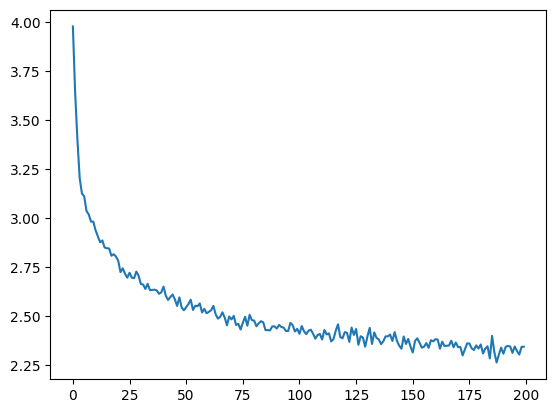

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## 네트워크 샘플링

샘플링을 위해서, 네트워크에 하나의 글자를 주고 다음 문자를 물어보고
이것을 다음 문자로 전달하는 것을 EOS 토큰까지 반복합니다.

-  입력 카테고리(언어), 시작 문자, 비어 있는 은닉 상태를 위한 Tensor를 생성하십시오
-  시작 문자로 ``output_name`` 문자열을 생성하십시오
-  최대 출력 길이까지,

   -  현재 문자를 네트워크에 전달하십시오.
   -  가장 높은 출력에서 다음 문자와 다음 은닉 상태를 얻으십시오
   -  만일 문자가 EOS면, 여기서 멈추십시오
   -  만일 일반적인 문자라면, ``output_name`` 에 추가하고 계속하십시오

-  마지막 이름을 반환하십시오

.. Note::
   시작 문자를 주는 것 외에 "문자열 시작" 토큰을 학습에
   포함되게 하고 네트워크가 자체적으로 시작 문자를 선택하게 하는
   다른 방법도 있습니다.




In [13]:
max_length = 20

# 카테고리와 시작 문자로 부터 샘플링 하기
def sample(category, start_letter='A'):
    with torch.no_grad():  # 샘플링에서 히스토리를 추적할 필요 없음
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# 하나의 카테고리와 여러 시작 문자들로 여러 개의 샘플 얻기
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Romant
Uakin
Shavent
Genter
Eren
Romen
Santer
Panter
Alla
Chan
Han
Iin


## Exercises

-  Try with a different dataset of category -> line, for example:

   -  Fictional series -> Character name
   -  Part of speech -> Word
   -  Country -> City

-  Use a "start of sentence" token so that sampling can be done without
   choosing a start letter
-  Get better results with a bigger and/or better shaped network

   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  상위 수준 네트워크로 여러 개의 이런 RNN을 결합해 보십시오


